In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import adjusted_rand_score
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')

Загружу данные о подтипе рака и преобразую подгруппы в числовые классы.

In [3]:
subtype = pd.read_csv('data5/true_labels.tsv', names=['cancer'])

le = preprocessing.LabelEncoder()
le.fit(subtype['cancer'])
le_subtype = le.transform(subtype['cancer'])
print(*list(le.classes_))

Basal Her2 LumA


Для кластеризации я выбрала метод Gaussian Mixture. Подобрала наиболее оптимальные параметры для модели и создала функцию.

In [5]:
def clust(dataset, verity, all_scores):
    pca = PCA(n_components = 10)
    
    data_pca = pca.fit_transform(dataset)
    
    data_predict = GaussianMixture(n_components = 3, 
                                   covariance_type = 'tied',
                                   tol = 0.0001,
                                   reg_covar = 0.1,
                                   n_init = 13,
                                   random_state = 4).fit_predict(data_pca)
    
    print('Score is', adjusted_rand_score(verity, data_predict))
    
    all_scores.append(adjusted_rand_score(verity, data_predict))
    
    for i in (verity, data_predict):
        sns.relplot(x = data_pca[:,0], y = data_pca[:,1], hue = i)

In [6]:
scores = [] # для итоговой таблицы

По очереди буду загружать датасеты с каждой омиксной платформой и считать качество кластеризации.

## miRNA

Score is 0.46617632678643595


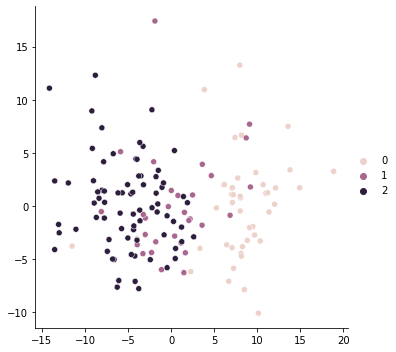

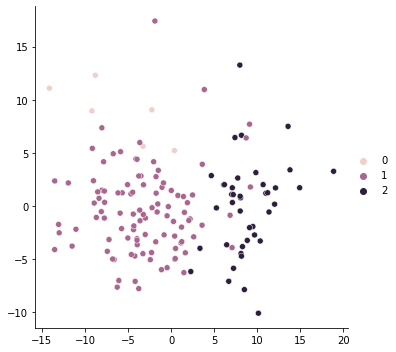

In [7]:
miRNA = (pd.read_csv('data5/miRNA.tsv',  sep = '\t', index_col = 0)).T
clust(miRNA, le_subtype, scores)

## mRNA

Score is 0.8961749331264166


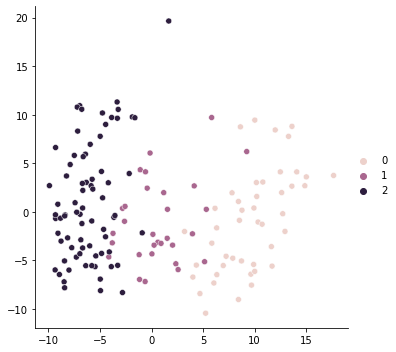

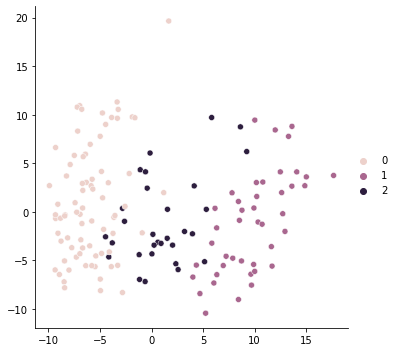

In [9]:
mRNA = (pd.read_csv('data5/mRNA.tsv',  sep = '\t', index_col = 0)).T
clust(mRNA, le_subtype, scores)

## Proteome

Score is 0.7786055087173093


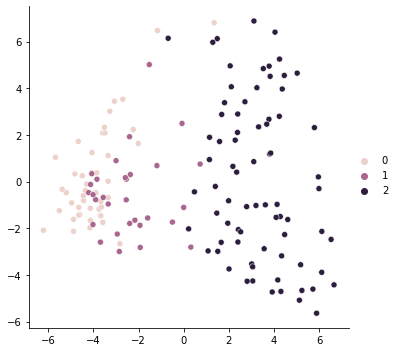

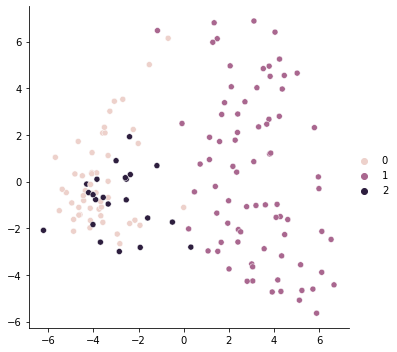

In [11]:
proteome = (pd.read_csv('data5/prot.tsv',  sep = '\t', index_col = 0)).T
clust(proteome, le_subtype, scores)

Теперь объединю попарно все три группы омиксных данных и проведу кластеризацию для объединенных групп.

## miRNA & mRNA

Score is 0.8961749331264166


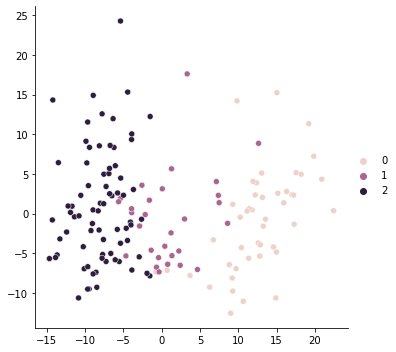

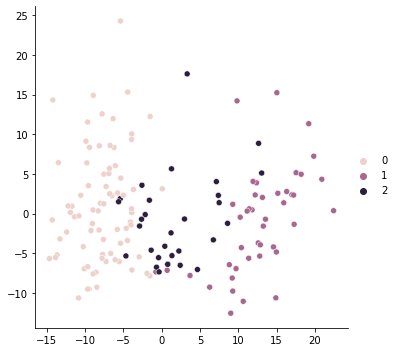

In [13]:
miRNA_mRNA = pd.concat([miRNA, mRNA], axis = 1)
clust(miRNA_mRNA, le_subtype, scores)

## mRNA & Proteome

Score is 0.9662898943819047


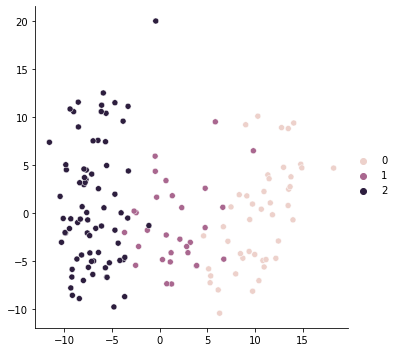

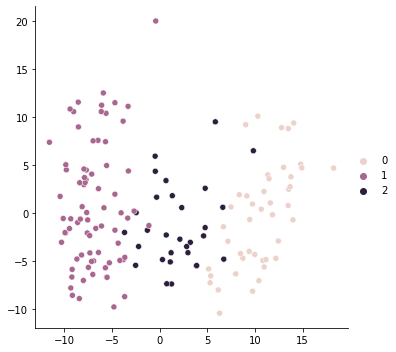

In [15]:
mRNA_proteome = pd.concat([mRNA, proteome], axis = 1)
clust(mRNA_proteome, le_subtype, scores)

## Proteome & miRNA

Score is 0.8654586359149379


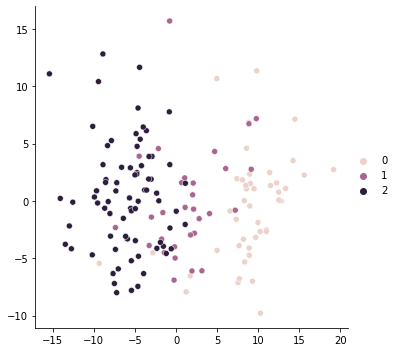

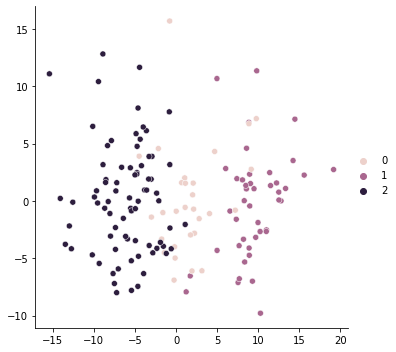

In [17]:
proteome_miRNA = pd.concat([proteome, miRNA], axis = 1)
clust(proteome_miRNA, le_subtype, scores)

Объединим всё вместе.

## miRNA & mRNA & Proteome

Score is 0.9327794852339927


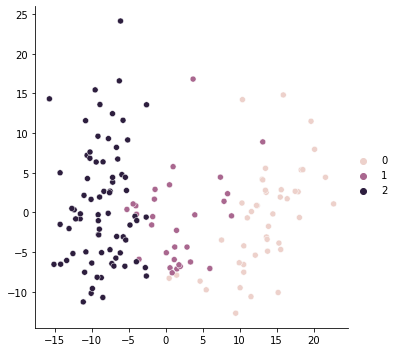

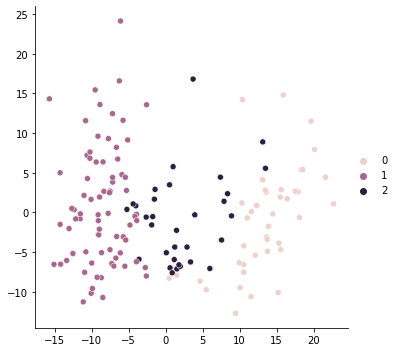

In [19]:
all_data = pd.concat([miRNA, mRNA, proteome], axis = 1)
clust(all_data, le_subtype, scores)

In [27]:
data_group = ['miRNA', 'mRNA', 'proteome', 'miRNA & mRNA', 'mRNA & proteome', 'proteome & miRNA', 'miRNA & mRNA & proteome']
for i in range(7):
    print(data_group[i], 'score is', format(scores[i], '.4f'))

miRNA score is 0.4662
mRNA score is 0.8962
proteome score is 0.7786
miRNA & mRNA score is 0.8962
mRNA & proteome score is 0.9663
proteome & miRNA score is 0.8655
miRNA & mRNA & proteome score is 0.9328


Самое лучшее качество кластеризации получается при использовании омиксных данных mRNA и протеома (аж 0.9663!). Данные miRNA особо не помогают улучшить результат: в связке с mRNA качество не изменилось (0.8962 у mRNA), а при использовании всех данных вместе результат хуже, чем у mRNA и протеома (0.9328). Только вместе с данными протеома получилось увеличить качество кластеризации с данными miRNA (0.7786 и 0.4662 по отдельности и 0.8655 вместе).

В итоге, лучше всего для кластеризации подходят данные только mRNA или вместе с данными протеома.